# *Enunciado*
1.      Desarrolle un modelo de identificación de objetos utilizando el dataset CIFAR10 u otro dataset simila (no se debe repetir el dataset), para imágenes del tamaño de **256x256 pixeles** y con **3 canales de colores**, utilizando un modelo convolucional que contemple **4 capa convolucionales** con sus **respectivas capas de pooling**, los parámetros para **las capas convolucionales** serán: **kernel = 5**, **padding = 0**, y el **strike = 2**, para **el pooling**: **kernel = 2**, **strike = 1**, en base a estos datos identificar con cuantas convoluciones se logra el mejor entrenamiento.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from zipfile import ZipFile
file_path = '/content/drive/MyDrive/Datasets/Tomato Leaves Dataset.zip'
with ZipFile(file_path, 'r') as zip:
  zip.extractall('.')

In [3]:
import os
PATH = '/content/train'

classes = os.listdir(PATH)
classes

['healthy',
 'Tomato_mosaic_virus',
 'Spider_mites Two-spotted_spider_mite',
 'Early_blight',
 'Bacterial_spot',
 'Late_blight',
 'powdery_mildew',
 'Leaf_Mold',
 'Septoria_leaf_spot',
 'Target_Spot',
 'Tomato_Yellow_Leaf_Curl_Virus']

In [4]:
# -------------------------------
from PIL import Image

imgs, labels = [], []

formatos_imagenes = [".png", ".jpg", ".jpeg", ".PNG", ".JPG", ".JPEG"]

for i, lab in enumerate(classes):
    paths = os.listdir(f'{PATH}/{lab}')
    print(f'Categoría: {lab}. Imágenes: {len(paths)}')
    paths = [p for p in paths if any(p.endswith(ext) for ext in formatos_imagenes)]

    for img_path in paths:
        img_full_path = f'{PATH}/{lab}/{img_path}'
        try:
            # Abrir la imagen con Pillow
            img = Image.open(img_full_path)
            # Verificar las dimensiones
            if img.mode == 'RGB':
                imgs.append(img_full_path)
                labels.append(i)
        except Exception as e:
            print(f"Error al procesar la imagen {img_full_path}: {str(e)}")

# Verificar el número total de imágenes
print("Número total de imágenes:", len(imgs))

Categoría: healthy. Imágenes: 3051
Categoría: Tomato_mosaic_virus. Imágenes: 2153
Categoría: Spider_mites Two-spotted_spider_mite. Imágenes: 1747
Categoría: Early_blight. Imágenes: 2455
Categoría: Bacterial_spot. Imágenes: 2826
Categoría: Late_blight. Imágenes: 3113
Categoría: powdery_mildew. Imágenes: 1004
Categoría: Leaf_Mold. Imágenes: 2754
Categoría: Septoria_leaf_spot. Imágenes: 2882
Categoría: Target_Spot. Imágenes: 1827
Categoría: Tomato_Yellow_Leaf_Curl_Virus. Imágenes: 2039
Número total de imágenes: 25498


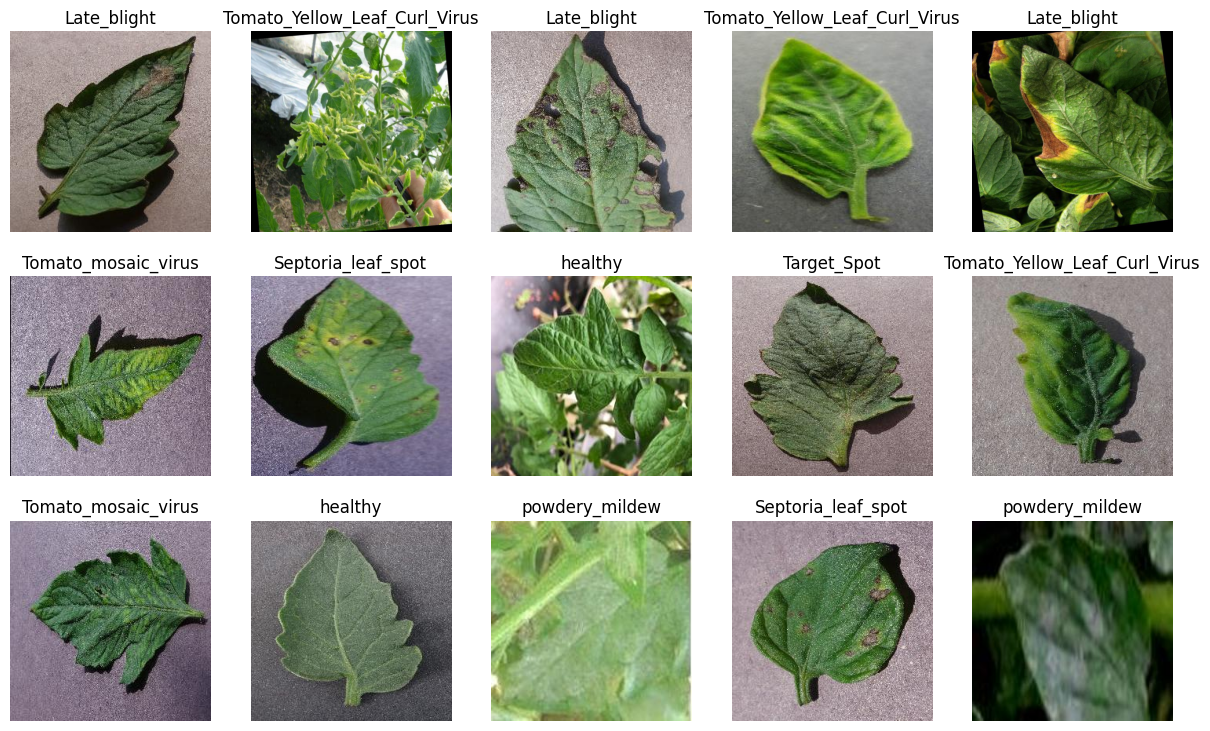

In [10]:
import random
from skimage import io
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3,5, figsize=(15,9))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(imgs)-1)
    img = io.imread(imgs[ix])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(classes[labels[ix]])
plt.show()

In [6]:
from sklearn.model_selection import train_test_split

train_imgs, test_imgs, train_labels, test_labels = train_test_split(imgs, labels, test_size=0.25, stratify=labels)

len(train_imgs), len(test_imgs)

(19123, 6375)

In [7]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, trans, device):
    self.X = X
    self.y = y
    self.trans = trans
    self.device = device

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    img = io.imread(self.X[ix])
    if self.trans:
      img = self.trans(image=img)["image"]
    return torch.from_numpy(img / 255.).float().permute(2,0,1), torch.tensor(self.y[ix])

In [8]:
import albumentations as A

trans = A.Compose([
    A.Resize(256, 256)
])

dataset = {
    'train': Dataset(train_imgs, train_labels, trans, device),
    'test': Dataset(test_imgs, test_labels, trans, device)
}

len(dataset['train']), len(dataset['test'])

(19123, 6375)

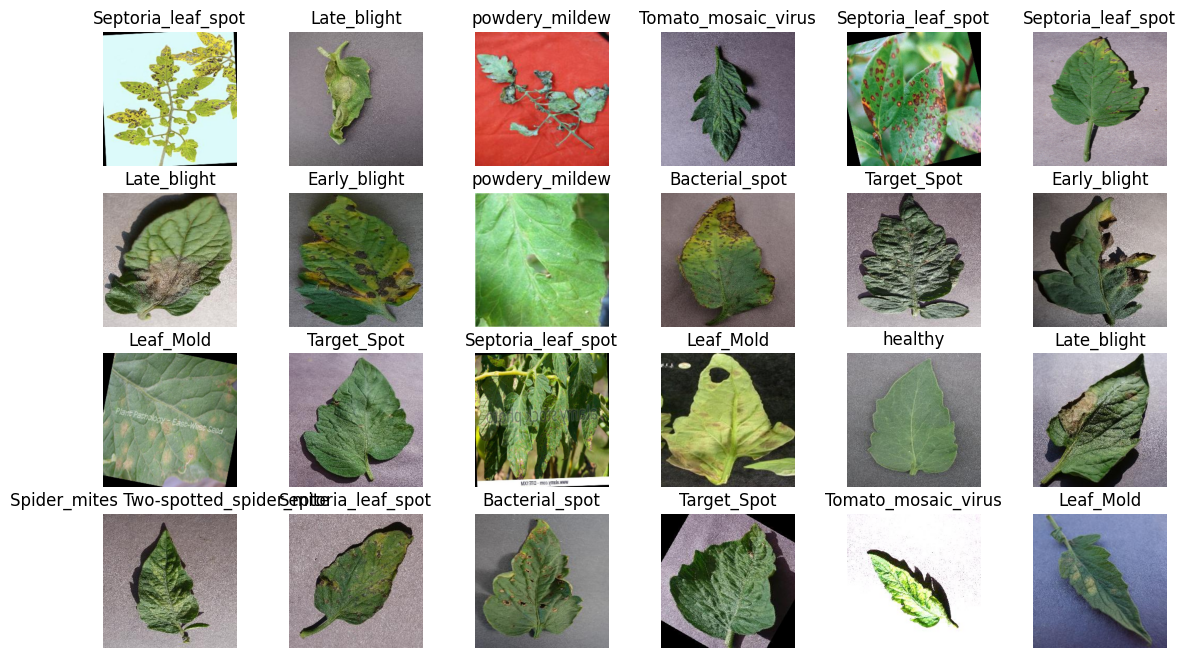

In [9]:
fig, axs = plt.subplots(4,6, figsize=(14,8))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(dataset['train'])-1)
    img, lab = dataset['train'][ix]
    ax.imshow(img.permute(1,2,0))
    ax.axis('off')
    ax.set_title(classes[lab])
plt.show()

In [11]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=64, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=256, shuffle=False)
}

imgs, labels = next(iter(dataloader['train']))
imgs.shape

torch.Size([64, 3, 256, 256])

In [12]:
import os
from tqdm import tqdm
import numpy as np

def fit(model, dataloader, epochs=10, lr=1e-2):
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

        checkpoint_path = f"checkpoint_epoch_{epoch}.pth"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
        }, checkpoint_path)

# 2 Capas

In [13]:
import torch.nn as nn

class ModelCustom(nn.Module):
    def __init__(self, n_outputs=11):
        super(ModelCustom, self).__init__()

        # Capa convolucional 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=0, stride=2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=1)

        # Capa convolucional 2
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=0, stride=2)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=1)

        # Capa completamente conectada (clasificación)
        self.fc = nn.Linear(230400, n_outputs)  # Ajustamos el tamaño de entrada en función de los cambios

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        # Aplanar la salida para la capa completamente conectada
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


In [14]:
model_custom = ModelCustom(n_outputs=11)
outputs = model_custom(torch.randn(64, 3, 256, 256))
print(outputs.shape)

torch.Size([64, 11])


In [15]:
model_c = ModelCustom(11)
fit(model_c, dataloader, epochs=10)

val_loss 1.55072 val_acc 0.46115: 100%|██████████| 25/25 [00:25<00:00,  1.04s/it]


Epoch 1/10 loss 1.89733 val_loss 1.55072 acc 0.34290 val_acc 0.46115


val_loss 1.17647 val_acc 0.62035: 100%|██████████| 25/25 [00:22<00:00,  1.12it/s]


Epoch 2/10 loss 1.40007 val_loss 1.17647 acc 0.52446 val_acc 0.62035


val_loss 1.77457 val_acc 0.41542: 100%|██████████| 25/25 [00:22<00:00,  1.09it/s]


Epoch 3/10 loss 1.14362 val_loss 1.77457 acc 0.61507 val_acc 0.41542


val_loss 1.06284 val_acc 0.65184: 100%|██████████| 25/25 [00:22<00:00,  1.11it/s]


Epoch 4/10 loss 0.95025 val_loss 1.06284 acc 0.68469 val_acc 0.65184


val_loss 0.97194 val_acc 0.69749: 100%|██████████| 25/25 [00:22<00:00,  1.11it/s]


Epoch 5/10 loss 0.88625 val_loss 0.97194 acc 0.71096 val_acc 0.69749


val_loss 0.89753 val_acc 0.72527: 100%|██████████| 25/25 [00:22<00:00,  1.12it/s]


Epoch 6/10 loss 0.73690 val_loss 0.89753 acc 0.76032 val_acc 0.72527


val_loss 0.92703 val_acc 0.71581: 100%|██████████| 25/25 [00:22<00:00,  1.11it/s]


Epoch 7/10 loss 0.69922 val_loss 0.92703 acc 0.77091 val_acc 0.71581


val_loss 0.88827 val_acc 0.72919: 100%|██████████| 25/25 [00:23<00:00,  1.07it/s]


Epoch 8/10 loss 0.57925 val_loss 0.88827 acc 0.81226 val_acc 0.72919


val_loss 0.88846 val_acc 0.72237: 100%|██████████| 25/25 [00:21<00:00,  1.16it/s]


Epoch 9/10 loss 0.50779 val_loss 0.88846 acc 0.83558 val_acc 0.72237


val_loss 0.84496 val_acc 0.74775: 100%|██████████| 25/25 [00:22<00:00,  1.13it/s]

Epoch 10/10 loss 0.47432 val_loss 0.84496 acc 0.84618 val_acc 0.74775


Precisión del **74%**

# 4 Capas

In [ ]:
import torch.nn as nn

class ModelCustom(nn.Module):
    def __init__(self, n_outputs=11):
        super(ModelCustom, self).__init__()

        # Capa convolucional 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=0, stride=2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=1)

        # Capa convolucional 2
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=0, stride=2)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=1)

        # Capa convolucional 3
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=0, stride=2)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=1)

        # Capa convolucional 4
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, padding=0, stride=2)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=1)

        # Capa completamente conectada (clasificación)
        self.fc = nn.Linear(30976, n_outputs)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        x = self.conv4(x)
        x = self.relu4(x)
        x = self.pool4(x)

        # Aplanar la salida para la capa completamente conectada
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


In [ ]:
model_custom = ModelCustom(n_outputs=11)
outputs = model_custom(torch.randn(64, 3, 256, 256))
print(outputs.shape)

torch.Size([64, 11])


In [ ]:
model_c = ModelCustom(11)
fit(model_c, dataloader, epochs=10)

val_loss 2.18562 val_acc 0.18934: 100%|██████████| 25/25 [00:22<00:00,  1.13it/s]


Epoch 1/10 loss 2.29863 val_loss 2.18562 acc 0.16096 val_acc 0.18934


val_loss 1.97755 val_acc 0.29837: 100%|██████████| 25/25 [00:22<00:00,  1.11it/s]


Epoch 2/10 loss 1.94281 val_loss 1.97755 acc 0.31721 val_acc 0.29837


val_loss 1.58698 val_acc 0.46580: 100%|██████████| 25/25 [00:22<00:00,  1.10it/s]


Epoch 3/10 loss 1.70784 val_loss 1.58698 acc 0.41165 val_acc 0.46580


val_loss 1.45613 val_acc 0.51894: 100%|██████████| 25/25 [00:21<00:00,  1.17it/s]


Epoch 4/10 loss 1.49802 val_loss 1.45613 acc 0.48720 val_acc 0.51894


val_loss 1.16752 val_acc 0.60174: 100%|██████████| 25/25 [00:21<00:00,  1.16it/s]


Epoch 5/10 loss 1.29582 val_loss 1.16752 acc 0.55925 val_acc 0.60174


val_loss 1.18862 val_acc 0.59741: 100%|██████████| 25/25 [00:22<00:00,  1.11it/s]


Epoch 6/10 loss 1.15953 val_loss 1.18862 acc 0.61307 val_acc 0.59741


val_loss 0.92271 val_acc 0.68899: 100%|██████████| 25/25 [00:23<00:00,  1.06it/s]


Epoch 7/10 loss 0.99135 val_loss 0.92271 acc 0.66077 val_acc 0.68899


val_loss 0.81740 val_acc 0.72795: 100%|██████████| 25/25 [00:21<00:00,  1.17it/s]


Epoch 8/10 loss 0.86872 val_loss 0.81740 acc 0.70511 val_acc 0.72795


val_loss 0.74827 val_acc 0.74919: 100%|██████████| 25/25 [00:24<00:00,  1.02it/s]


Epoch 9/10 loss 0.79070 val_loss 0.74827 acc 0.73764 val_acc 0.74919


val_loss 0.82525 val_acc 0.72235: 100%|██████████| 25/25 [00:23<00:00,  1.08it/s]

Epoch 10/10 loss 0.74937 val_loss 0.82525 acc 0.74869 val_acc 0.72235


Precisión del **72%**

# 5 Capas

In [ ]:
import torch.nn as nn

class ModelCustom(nn.Module):
    def __init__(self, n_outputs=11):
        super(ModelCustom, self).__init__()

        # Capa convolucional 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=0, stride=2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=1)

        # Capa convolucional 2
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=0, stride=2)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=1)

        # Capa convolucional 3
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=0, stride=2)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=1)

        # Capa convolucional 4
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, padding=0, stride=2)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=1)

        # Capa convolucional 5
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=5, padding=0, stride=2)
        self.relu5 = nn.ReLU()
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=1)

        # Capa completamente conectada (clasificación)
        self.fc = nn.Linear(4608, n_outputs)  # Ajustamos el tamaño de entrada en función de los cambios

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        x = self.conv4(x)
        x = self.relu4(x)
        x = self.pool4(x)

        x = self.conv5(x)
        x = self.relu5(x)
        x = self.pool5(x)

        # Aplanar la salida para la capa completamente conectada
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [ ]:
model_custom = ModelCustom(n_outputs=11)
outputs = model_custom(torch.randn(64, 3, 256, 256))
print(outputs.shape)

torch.Size([64, 11])


In [ ]:
model_c = ModelCustom(11)
fit(model_c, dataloader, epochs=10)

val_loss 2.35833 val_acc 0.11231: 100%|██████████| 25/25 [00:21<00:00,  1.14it/s]


Epoch 1/10 loss 2.37270 val_loss 2.35833 acc 0.11652 val_acc 0.11231


val_loss 2.34314 val_acc 0.13127: 100%|██████████| 25/25 [00:21<00:00,  1.17it/s]


Epoch 2/10 loss 2.35297 val_loss 2.34314 acc 0.12430 val_acc 0.13127


val_loss 2.10594 val_acc 0.30235: 100%|██████████| 25/25 [00:21<00:00,  1.17it/s]


Epoch 3/10 loss 2.26317 val_loss 2.10594 acc 0.18391 val_acc 0.30235


val_loss 1.85005 val_acc 0.33545: 100%|██████████| 25/25 [00:21<00:00,  1.16it/s]


Epoch 4/10 loss 1.95010 val_loss 1.85005 acc 0.30610 val_acc 0.33545


val_loss 1.66958 val_acc 0.41996: 100%|██████████| 25/25 [00:22<00:00,  1.13it/s]


Epoch 5/10 loss 1.74902 val_loss 1.66958 acc 0.38245 val_acc 0.41996


val_loss 1.42748 val_acc 0.51446: 100%|██████████| 25/25 [00:22<00:00,  1.12it/s]


Epoch 6/10 loss 1.59872 val_loss 1.42748 acc 0.44446 val_acc 0.51446


val_loss 1.61970 val_acc 0.45306: 100%|██████████| 25/25 [00:22<00:00,  1.12it/s]


Epoch 7/10 loss 1.46518 val_loss 1.61970 acc 0.49611 val_acc 0.45306


val_loss 1.25913 val_acc 0.56100: 100%|██████████| 25/25 [00:22<00:00,  1.12it/s]


Epoch 8/10 loss 1.33785 val_loss 1.25913 acc 0.54288 val_acc 0.56100


val_loss 1.15583 val_acc 0.59706: 100%|██████████| 25/25 [00:21<00:00,  1.16it/s]


Epoch 9/10 loss 1.20997 val_loss 1.15583 acc 0.58170 val_acc 0.59706


val_loss 1.08972 val_acc 0.61638: 100%|██████████| 25/25 [00:22<00:00,  1.11it/s]

Epoch 10/10 loss 1.10183 val_loss 1.08972 acc 0.62153 val_acc 0.61638


Precisión del **61%**

# 3 Capas

In [ ]:
import torch.nn as nn

class ModelCustom(nn.Module):
    def __init__(self, n_outputs=11):
        super(ModelCustom, self).__init__()

        # Capa convolucional 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=0, stride=2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=1)

        # Capa convolucional 2
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=0, stride=2)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=1)

        # Capa convolucional 3
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=0, stride=2)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=1)

        # Capa completamente conectada (clasificación)
        self.fc = nn.Linear(93312, n_outputs)  # Ajustamos el tamaño de entrada en función de los cambios

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        # Aplanar la salida para la capa completamente conectada
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


In [ ]:
model_custom = ModelCustom(n_outputs=11)
outputs = model_custom(torch.randn(64, 3, 256, 256))
print(outputs.shape)

torch.Size([64, 11])


In [ ]:
model_c = ModelCustom(11)
fit(model_c, dataloader, epochs=10)

val_loss 1.75758 val_acc 0.41662: 100%|██████████| 25/25 [00:21<00:00,  1.16it/s]


Epoch 1/10 loss 2.05988 val_loss 1.75758 acc 0.26933 val_acc 0.41662


val_loss 1.74233 val_acc 0.40932: 100%|██████████| 25/25 [00:21<00:00,  1.17it/s]


Epoch 2/10 loss 1.57361 val_loss 1.74233 acc 0.45173 val_acc 0.40932


val_loss 1.56033 val_acc 0.43704: 100%|██████████| 25/25 [00:21<00:00,  1.18it/s]


Epoch 3/10 loss 1.34974 val_loss 1.56033 acc 0.53653 val_acc 0.43704


val_loss 1.48452 val_acc 0.48346: 100%|██████████| 25/25 [00:21<00:00,  1.17it/s]


Epoch 4/10 loss 1.18965 val_loss 1.48452 acc 0.59822 val_acc 0.48346


val_loss 0.99107 val_acc 0.66417: 100%|██████████| 25/25 [00:20<00:00,  1.19it/s]


Epoch 5/10 loss 1.02902 val_loss 0.99107 acc 0.65469 val_acc 0.66417


val_loss 1.08914 val_acc 0.62770: 100%|██████████| 25/25 [00:22<00:00,  1.13it/s]


Epoch 6/10 loss 0.92641 val_loss 1.08914 acc 0.68850 val_acc 0.62770


val_loss 0.85825 val_acc 0.71845: 100%|██████████| 25/25 [00:21<00:00,  1.14it/s]


Epoch 7/10 loss 0.82526 val_loss 0.85825 acc 0.72285 val_acc 0.71845


val_loss 0.81998 val_acc 0.72173: 100%|██████████| 25/25 [00:21<00:00,  1.16it/s]


Epoch 8/10 loss 0.76079 val_loss 0.81998 acc 0.74747 val_acc 0.72173


val_loss 1.10666 val_acc 0.64236: 100%|██████████| 25/25 [00:21<00:00,  1.14it/s]


Epoch 9/10 loss 0.68573 val_loss 1.10666 acc 0.77400 val_acc 0.64236


val_loss 0.73314 val_acc 0.76101: 100%|██████████| 25/25 [00:20<00:00,  1.22it/s]

Epoch 10/10 loss 0.62708 val_loss 0.73314 acc 0.79214 val_acc 0.76101


Precisión del **76%**

# Vizualización de las predicciones


In [27]:
import matplotlib.pyplot as plt
import numpy as np

def visualizacionEntrenamiento(model, dataloader):
    model.eval()
    count = 0
    fig, axs = plt.subplots(4, 5, figsize=(10, 8))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    with torch.no_grad():
        for batch in dataloader:
            X, y = batch
            X = X.to('cuda')
            y_pred = model(X)
            y_pred = torch.argmax(y_pred, axis=1)
            y = y.to('cuda')
            images = X.permute(0, 2, 3, 1).cpu().numpy()
            for i in range(images.shape[0]):
                if count >= 20:
                    break
                image = images[i]
                label = y[i].item()
                prediction = y_pred[i].item()
                row = count // 5
                col = count % 5
                axs[row, col].imshow(image)
                title_color = 'green' if prediction == label else 'red'
                axs[row, col].set_title(f"Pred: {prediction}, C: {label}", color=title_color)
                axs[row, col].axis('off')
                count += 1
            if count >= 20:
                break
    plt.show()


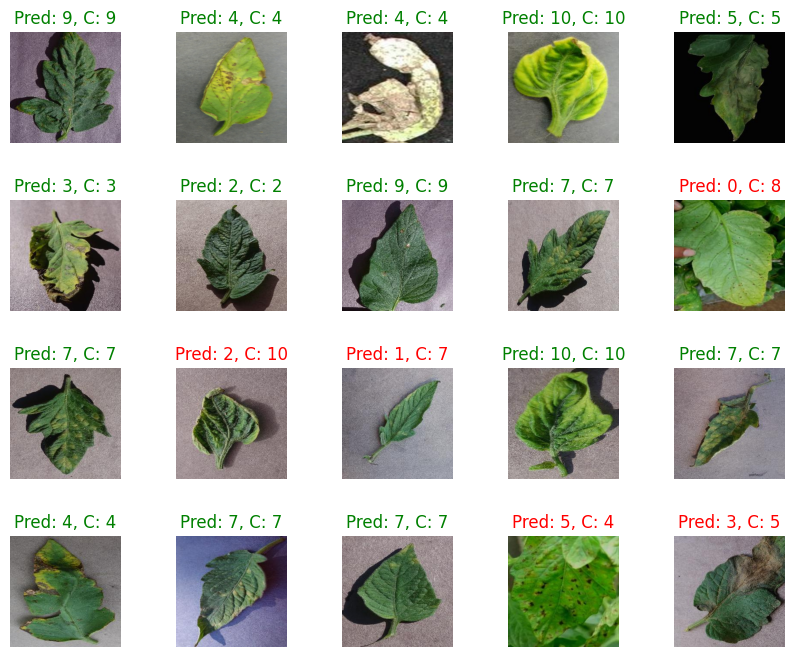

In [28]:
visualizacionEntrenamiento(model_c, dataloader['test'])